# Attempting a minimal diffusion model

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from matplotlib import pyplot as plt
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.learner import *
from fastprogress import progress_bar

Load a dataset:

In [ ]:
x,y = 'image','label'
name = "mnist" #"fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]
    
bs = 64
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

/home/ubuntu/mambaforge/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Found cached dataset mnist (/home/ubuntu/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([64, 1, 28, 28]), tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))

Define a model:

In [ ]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            h.append(x)
            if i < 2: x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0: x = self.upscale(x)
            x += h.pop()
            x = self.act(l(x))
        return x

Define the corruption:

In [ ]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount

Logging callback:

In [ ]:
class LogLossesCB(Callback):
    def __init__(self): self.losses = []
    def after_batch(self): self.losses.append(self.learn.loss.item())
    def after_fit(self):plt.plot(self.losses)

I chose to write a new training callback:

In [ ]:
class MyTrainCB(TrainCB):
    def predict(self):
        bs = self.learn.batch[0].shape[0]
        noise_amount = torch.rand(bs).to(self.learn.batch[0].device) # Chose random corruption amount
        noisy_images = corrupt(self.learn.batch[0], noise_amount) # Noisy images as net inputs
        self.learn.preds = self.learn.model(noisy_images)
    def get_loss(self):
        self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[0]) # Clean images as targets

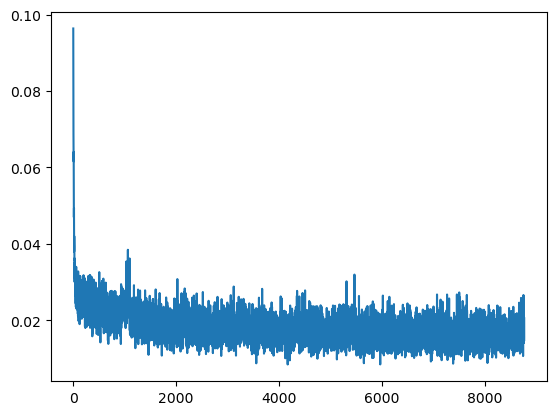

In [ ]:
model = BasicUNet(1, 1)
cbs = [MyTrainCB(), CudaCB(), ProgressCB(), LogLossesCB()]
learn = Learner(model, dls, nn.MSELoss(), lr=5e-4, cbs=cbs, opt_func=optim.Adam)
learn.fit(8) 

Viewing the predictions on images with increasing noise levels:

<matplotlib.image.AxesImage>

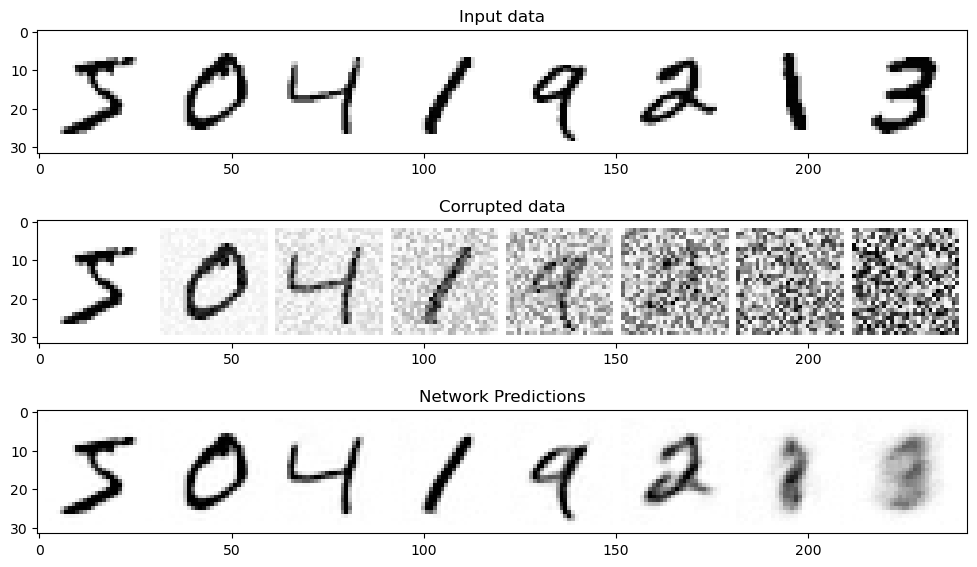

In [ ]:
# Some noisy data
xb = xb[:8].cuda()
amount = torch.linspace(0, 1, xb.shape[0]).cuda() # Left to right -> more corruption
noised_x = corrupt(xb, amount)

# Get the model predictions
with torch.no_grad():
    preds = model(noised_x.to(xb.device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(xb).cpu()[0], cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x).cpu()[0], cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds).cpu().clip(0, 1)[0], cmap='Greys')

A very basic sampling method (not ideal), just taking 5 or 10 equal-sized steps towards the models prediction:

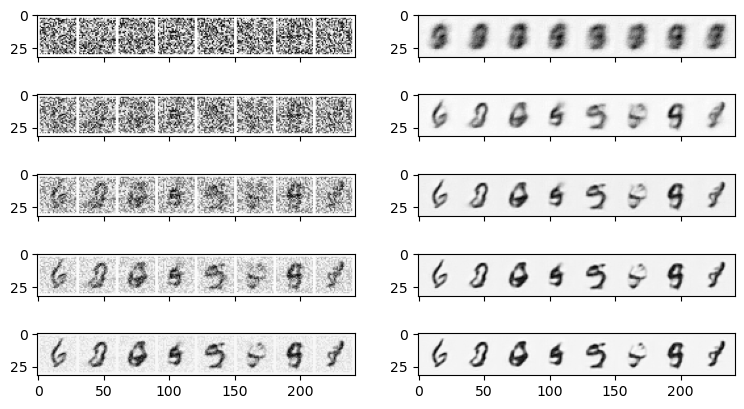

In [ ]:
# Take one: just break the process into 5 or 10 steps and move 1/10'th of the way there each time:
device = 'cuda'
n_steps = 5
xb = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [xb.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = model(xb) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    xb = xb*(1-mix_factor) + pred*mix_factor # Move part of the way there
    if i < n_steps-1: step_history.append(xb.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, n_steps), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys'),
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0], cmap='Greys')

# Class Conditioning

Giving the model the labels as conditioning.

In [ ]:
class ClassConditionedUNet(nn.Module):
    """Wraps a BasicUNet but adds several input 
    channels for class conditioning. An nn.Embedding layer maps num_classes to class_emb_channels."""
    def __init__(self, in_channels, out_channels, num_classes=10, class_emb_channels=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_channels) # Map num_classes discrete classes to class_emb_channels numbers
        self.net = BasicUNet(in_channels+class_emb_channels, out_channels) # Note input channels = in_channels+1+class_emb_channels

    def forward(self, x, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # And the class cond
        class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Reshape
        
        # Net input is now x, noise amound and class cond concatenated together
        net_input = torch.cat((x, class_cond), 1)
        return self.net(net_input)

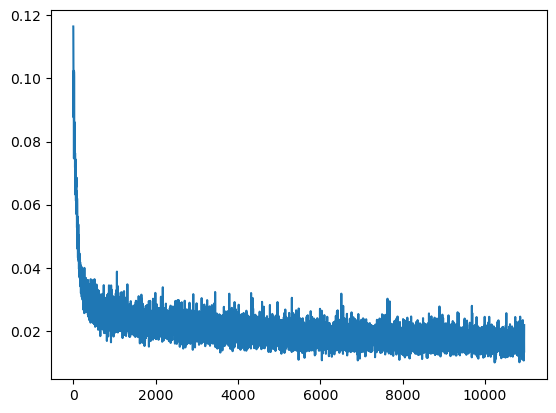

In [ ]:
class MyTrainCB(TrainCB):
    def predict(self):
        bs = self.learn.batch[0].shape[0]
        noise_amount = torch.rand(bs).to(self.learn.batch[0].device)
        noisy_images = corrupt(self.learn.batch[0], noise_amount)
        self.learn.preds = self.learn.model(noisy_images, self.learn.batch[1]) # << Labels as conditioning
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[0])
model = ClassConditionedUNet(1, 1)
cbs = [MyTrainCB(), CudaCB(), ProgressCB(), LogLossesCB()]
learn = Learner(model, dls, nn.MSELoss(), lr=1e-4, cbs=cbs, opt_func=optim.Adam)
learn.fit(10)

Sampling as before over 20 steps, but this time with the labels as conditioning:

<matplotlib.image.AxesImage>

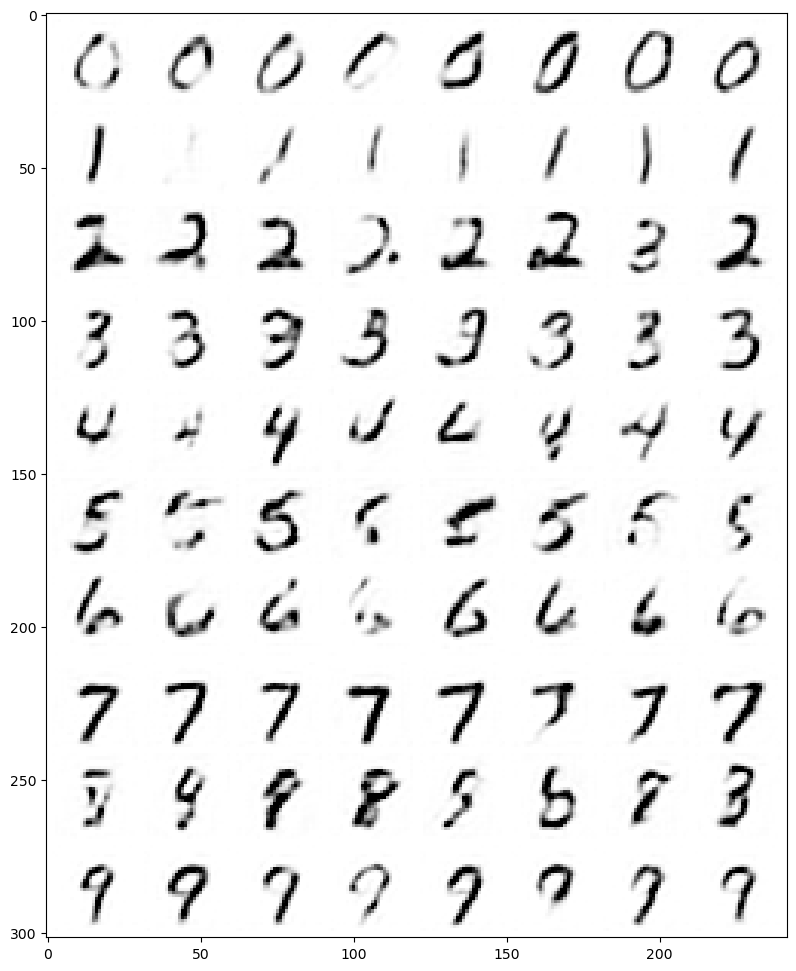

In [ ]:
n_steps = 20
device='cuda'
xb = torch.rand(80, 1, 28, 28).to(device)
yb = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
for i in range(n_steps):
    noise_amount = torch.ones((xb.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad():
        pred = model(xb, yb)
    mix_factor = 1/(n_steps - i)
    xb = xb*(1-mix_factor) + pred*mix_factor
    
    # Optional: Add a bit of extra noise back at early steps
    if i < 10: xb = corrupt(xb, torch.ones((xb.shape[0], )).to(device)*0.05)
        
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(xb.detach().cpu().clip(0, 1), nrow=8)[0], cmap='Greys')

You can try fashion_mnist as the dataset without making any changes. This seems to work (suprisingly given the lack of fiddling with training and architecture). 